In [238]:
import urllib.request
import bs4
from bs4 import BeautifulSoup
import re
import os
import json
import matplotlib.pyplot as plt
from subprocess import check_output
import pandas as pd
from datetime import datetime
import timeit

In [192]:
def timestampToHuman(date):
    return datetime.utcfromtimestamp(date / 1000).strftime('%d%m%Y_%H%M%S')


def getTimeStampFromData(modelJSON):
    date = modelJSON[0]["DSServices"]["date"]
    return date


def downloadTeslaModelPage(url):
    response = urllib.request.urlopen(url)
    html = response.read().decode()
    soup = bs4.BeautifulSoup(html)
    return soup


def buildIDForJSONFile(model, locale, downloadDate):
    return f"{model}_{locale}_{downloadDate}"


def getLocale(modelJSON):
    locale = ""
    if(len(modelJSON) > 1):
        locale = modelJSON[1]["App"]["locale"]
    else:
        locale = modelJSON[0]["App"]["locale"]
    return locale
    


def getDownloadDate(jsonData):
    return timestampToHuman(getTimeStampFromData(jsonData))


def getDate(modelJSON):
    """Returns the time of data download as Milliseconds EPOCH"""
    return modelJSON[0]["DSServices"]["date"]


def getModel(modelJSON):
    """Returns the Model Name as shortcut like my for ModelY or m3 for Model3"""
    return modelJSON[0]["DSServices"]["KeyManager"]["keys"]["Lexicon"][0]["query"]["model"]


def getLexicon(modelJSON):
    """Returns the Lxicon for given modelJSON"""
    lexiconKey = modelJSON[0]["DSServices"]["KeyManager"]["keys"]["Lexicon"][0]["key"]
    return modelJSON[0]["DSServices"][lexiconKey]



def getExportData(jsonData):
    return {
        "model": getModel(jsonData),
        "locale": getLocale(jsonData),
        "downloadDate": getDownloadDate(jsonData)
    }


def exportRawJSONData(modelData):
    exportData = getExportData(modelData)
    exportID = buildIDForJSONFile(exportData["model"], exportData["locale"], exportData["downloadDate"])
    exportFilename = "raw_" + exportID + '.json'

    exportJSONToFile(data_dir + exportFilename, modelData)


def deleteTempJavascriptFile(tempFile):
    os.remove(tempFile)

    
def getTeslaModelJSON(soup_page):
    script = soup_page.find('script', text=re.compile(r'dataJson'))
    matches = re.finditer(r'const\s*\w*\s*=\s*\{.+?\};', script.text, re.DOTALL)
    dict_matches = [re.sub(r'const\s*\w*\s*=\s*', '', match.group(0)).rstrip(";") for match in matches]
    concat_dicts = ",".join(dict_matches)
    js_export_json_string = 'const teslaData = [' + concat_dicts + '];\nprocess.stdout.write(JSON.stringify(teslaData));'
    with open('temp.js', 'w') as f:
        f.write(js_export_json_string)
    modelData = json.loads(check_output(['node','temp.js']).decode())
    deleteTempJavascriptFile("temp.js")

    exportRawJSONData(modelData)
    return exportFilename


def exportJSONToFile(filename, data):
    with open(filename, 'w') as f:
        json.dump(data, f)


def importModelJSON(json_file):
    with open(json_file, 'r') as f:
        return f.read()

In [3]:
# LOCALE SELECTOR!
localeSelectorJSON = json.loads(modelyJSON[1]["App"]["localeSelector"])
regionsList = localeSelectorJSON["localeSelector"]

def getCountryCode(regionsList):
    country_list = []
    for region in regionsList:
        continent = region["regions"]
        for continentList in continent:
            countries = continentList["countries"]
            for country in countries:
                countryName = country["countryName"]
                locale = country["languages"][0]["localeCode"] 
                country_list.append({
                    "country": countryName,
                    "locale": locale
                })
    
    return country_list

country_codes = getCountryCode(regionsList)

NameError: name 'modelyJSON' is not defined

## Get Vehicle Information
- Get base price for "Model Y Long Range" (65990)
- Get Est. Delivery in same format as on webpage (Jan - Mar 2023)
- Get available information: Range, Top Speed, Acceleration
- Get all available trims (Long Range + Performance
)
- Get all Options with prices: (color, wheels, tow hitch, interior, seats, enhaced Autopilot, FSD, charging: wall connector + mobile connector)

In [4]:
def dateStringToMonth(datestring, date_format='%m/%d/%Y %H:%M:%S'):
    date = datetime.strptime(datestring, date_format)
    year = date.year
    month_string = date.strftime('%B')
    return month_string, year


def estDeliveryString(start, end, date_format='%m/%d/%Y %H:%M:%S'):
    """Takes the start and end date in the format '%m/%d/%Y %H:%M:%S' and returns the string in the formart 
    Month - Month YEAR.
    If the Years are different, it will return
    Month YEAR - Month YEAR"""
    start = dateStringToMonth(start)
    end = dateStringToMonth(end)
    if start[1] == end[1]:
        date_string = f'{start[0]} - {end[0]} {end[1]}'
    else:
        date_string = f'{start[0]} {start[1]} - {end[0]} {end[1]}'
    
    return date_string


def getDeliveryEstForTrim(trim, modelJSON):
    eD = eddDataForModel(trim, modelJSON)
    deliveryEstForTrim = deliveryEstimateForModel(eD)
    eddString = estDeliveryString(deliveryEstForTrim["start"], deliveryEstForTrim["end"])
    
    deliveryEstimate = {
        "start": deliveryEstForTrim["start"],
        "end": deliveryEstForTrim["end"],
        "text": eddString
    }
    
    return deliveryEstimate


def getAllTrims(modelJSON):
    lexicon = getLexicon(modelJSON)
    trims = lexicon["sku"]["trims"]
    return trims

def getConfigurableTrims(modelJSON):
    """Scrapes the JSON scraped from the Tesla webpage and returns a dictionary of all configurable trims with corresponding options"""
    all_trims = getAllTrims(modelJSON)
    configurable_trims = {k: v for k, v in all_trims.items() if "configurator" in v}
    return configurable_trims


def explainConfigurableTrims(configurable_trims):
    """Takes the trims dictionary and returns a dictionary with the shortcut and the corresponding name"""
    new_dict = {}
    for key, value in configurable_trims.items():
        new_dict[key] = value["variant"]["name"]
    
    return new_dict

def explainTrim(trim):
    """Takes the shortcut of one trim and returns the name/description of the trim"""
    try:
        return configurable_trims[trim]["variant"]["name"]
    except:
        print("There is no trim available with the shortcut " + trim)
        

def priceForOption(option, modelJSON):
    """Receives the option as '$MTY05' and the modelJSON and returns the price for that option"""
    lexicon = getLexicon(modelJSON)
    
    price = lexicon["options"][option]["price"]
    for jsonObj in lexicon["options"][option]["pricing"]:
        if jsonObj["type"] == "base_plus_trim":
            price = jsonObj["value"]
    
    return price


def nameForOption(option, modelJSON):
    """Receives the option in '$MTY05' format and the modelJSON, return the name of the option"""
    lexicon = getLexicon(modelJSON)
    
    name = lexicon["options"][option]["long_name"]
    return name


def eddDataForModel(model, modelJSON):
    """Returns the estimated Delivery Data for given model
    Inputs:
    - model = '$MTY05'
    - modelJSON = the Model JSON object
    
    Returns:
    List with estDeliveryData for given model
    """
    
    edd = modelJSON[1]["eddData"]
    eddForModel = []
    
    for option in edd:
        if model in option["options"]:
            eddForModel.append(option)
    
    return eddForModel


def getValidEddData(eddDataForModel):
    """Throws away the inStart and inEnd dates that have type None.
    Returns a list of valid est Delivery Data"""
    
    validEddData = []
    for key, value in enumerate(eddDataForModel):
        if value["inStart"] is not None and value["inEnd"] is not None:
            validEddData.append(value)
            
    return validEddData


def deliveryEstimateForModel(eddDataForModel):
    """takes the estDelivery Data  as a list of objects 
    and returns the start, end and outliers as dict"""
    validEddData = getValidEddData(eddDataForModel)
    start = eddDataForModel[0]["inStart"]
    end = eddDataForModel[0]["inEnd"]
    
    deliveryEst = {
        "start": start,
        "end": end,
        "outliers": []
    }
        
    for obj in validEddData:
        if obj["inStart"] != start and obj["inEnd"] != end:
            deliveryEst["outliers"].append(obj)
    return deliveryEst


def allTrimsInfo(modelJSON):
    trims = {}
    configurable_trims = getConfigurableTrims(modelJSON)
    trimsList = list(configurable_trims.keys())
    for trim in trimsList:
        trimName, trimData = getTrimInfo(trim, modelJSON)
        trims[trimName] = trimData
    
    return trims




def specChangingOptions(specs):
    try:
        overrides = specs["overrides"]
        for override in overrides:
            for key, option in enumerate(override['selected_by']['and']):
                if option.startswith('$'):
                    override['selected_by']['and'][key] = getOptionPriceAndName(option, modelJSON)
    except:
        overrides = {}
    return overrides


def optionsCodeWithExplanation(modelJSON):
    options = getLexicon(modelJSON)["options"]
    new_dict = {}
    for key, value in options.items():
        new_dict[key] = value["name"]
        
    return new_dict


def getOptionPriceAndName(option, modelJSON):
    """For a given option returns the dicitonary
    {
        shortcut: $MTY05
        name: "White Interior",
        price: 1200,
    }
    """
    lexicon = getLexicon(modelJSON)
    try:
        price = lexicon["options"][option]["price"]
        for jsonObj in lexicon["options"][option]["pricing"]:
            if jsonObj["type"] == "base_plus_trim":
                price = jsonObj["value"]
    except KeyError:
        price = None
        
    try:
        name = lexicon["options"][option]["name"]
    except KeyError:
        name = None
                
    optionData = {
        "shortcut": option,
        "name": name,
        "price": price,
    }
    
    
    return optionData


# All available options
def getPriceOptions(modelJSON):
    """Takes the options object/dict as input and return a dictionary with the options and their correpsonding pricing"""
    lexicon = getLexicon(modelJSON)
    new_dict = {}
    important_values = ["name", "price", "pricing"]
    result = {key: {k: v for k, v in value.items() if k in important_values} for key, value in lexicon["options"].items()}
    return result


def getStandardConfiguration(trim, modelJSON):
    """For the gibven trim returns the base_options list with dicts for the option, price and shortcut"""
    standardConfig = []
    lexicon = getLexicon(modelJSON)
    base_options = lexicon["sku"]["trims"][trim]["configurator"][0]["base_options"]
    for option in base_options:
        standardConfig.append(getOptionPriceAndName(option, modelJSON))
    return standardConfig


def getAvailableOptions(trim, modelJSON):
    """Returns a dict with the available options with their names, prices and shortcuts"""
    availableOptions = []
    lexicon = getLexicon(modelJSON)
    
    combinations = lexicon["sku"]["trims"][trim]["configurator"][0]["combinations"]
    for combi in combinations:
        for option in combi:
            availableOptions.append(getOptionPriceAndName(option, modelJSON))
        
    return availableOptions



def getMetaData(modelJSON):
    lexicon = getLexicon(modelJSON)
    meta = lexicon["metadata"]
    metaData = {
        "country": modelJSON[1]["App"]["uiCountry"],
        "currency": meta["currency_code"],
        "symbol": meta["currency_symbol"],
        "range_units": meta["specs"]["data"][0]["meta"]["specs"]["range"]["units"],
        "range_source": meta["specs"]["data"][0]["meta"]["specs"]["range"]["source"]
    }
    return metaData


def getTrimInfo(trim, modelJSON):
    """Returns the Trim Info for given trim
    Input:
    - trim = '$MTY05'
    - modelJSON = The model JSON
    
    Returns:
    - trimName as String
    - trimDict as dict with price, delivery est."""
    
    trimName = nameForOption(trim, modelJSON)
    trimDict = {
        "price": priceForOption(trim, modelJSON),
        "deliveryEstimate": getDeliveryEstForTrim(trim, modelJSON),
        "specs": getSpecsForTrim(trim, modelJSON),
        "standard_config":  getStandardConfiguration(trim, modelJSON),
        "options": getAvailableOptions(trim, modelJSON)
    }
    
    
    return trimName, trimDict




# Spec for Trim
def getSpecsForTrim(trim, modelJSON):
    """Takes the trim and modelJSON and returns a list
    with the specs: 
    - range
    - max-speed
    - acceleartion
    """
    lexicon = getLexicon(modelJSON)
    trimSpecs = lexicon["metadata"]["specs"]["data"][0]["options"][trim]
    specs = {
        "range": trimSpecs["range"],
        "topspeed": trimSpecs["topspeed"],
        "acceleration": trimSpecs["acceleration"],
        "overrides": specChangingOptions(trimSpecs)
    }
    
    return specs


def getModelData(modelJSON):
    modelData = {
        "model": getModel(modelJSON),
        "date": getDate(modelJSON),
        "meta": getMetaData(modelJSON),
        "trims": allTrimsInfo(modelJSON),
        "options": getPriceOptions(modelJSON)
    }
    return modelData

In [5]:
### Helper Function

def explainThisOption(option):
    """Returns the name/description of the prompted option"""
    explanation = ""
    if "$" in option:
        explanation = explainedOptions[option]
    else:
        explanation = explainedOptions["$" + option]
    return explanation


In [9]:
#######################################################################

In [10]:
models = ["models", "model3", "modelx", "modely"]
country_codes = []
data_dir = "data/"

In [28]:
for model in models[:2]:
    url = f"https://www.tesla.com/{model}/design#overview"
    modely_page = downloadTeslaModelPage(url)
    filename = getTeslaModelJSON(modely_page)
    modelJSON = json.loads(importModelJSON(data_dir + filename))
    
    modelData = getModelData(modelJSON)
    exportJSONToFile(data_dir + filename[4:], modelData)

In [11]:
# Read all JSON for ModelY
files = [file for file in os.listdir(data_dir) if file.startswith("my_")]
files

['my_en_US_16012023_193238.json',
 'my_en_US_18012023_230143.json',
 'my_en_US_19012023_074507.json']

In [12]:
data = []
for file in files:
    fileJSON = importModelJSON(data_dir + file)
    data.append(json.loads(fileJSON))

In [13]:
for d in data:
    print(d["trims"].keys())

dict_keys(['Model Y Performance Dual Motor All-Wheel Drive', 'Model Y Long Range Dual Motor All-Wheel Drive'])
dict_keys(['Model Y Performance Dual Motor All-Wheel Drive', 'Model Y Long Range Dual Motor All-Wheel Drive'])
dict_keys(['Model Y Performance Dual Motor All-Wheel Drive', 'Model Y Long Range Dual Motor All-Wheel Drive'])


In [139]:
def trimPriceDataToPlot():
    for trim in list(data[0]["trims"].keys()):
        trimPrices[trim] = {
            "prices": [],
            "dates": []
        }


    for item in data:
        for model in item["trims"].keys():
            trimPrices[model]["prices"].append(item["trims"][model]["price"])
            trimPrices[model]["dates"].append(item["date"])
    
    return trimPrices

In [140]:
def visualizeTrim(trim):
    # filter the data to only include "Model Y Long Range Dual Motor All-Wheel Drive"
    filtered_data = [d for d in prices if d['model'] == trim]

    # extract the date and price values
    dates = [d['date'] for d in filtered_data]
    modelPrices = [d['price'] for d in filtered_data]

    return dates, modelPrices

In [141]:
trimPrices = trimPriceDataToPlot()

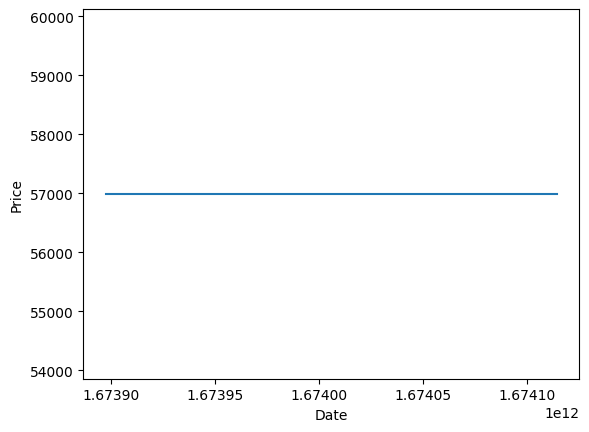

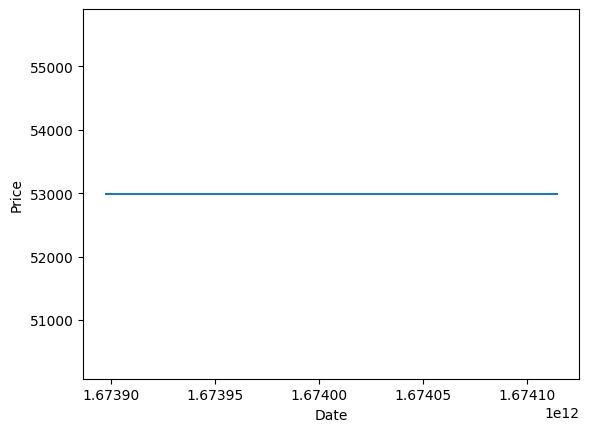

In [149]:
for trim in list(trimPrices.keys()):
    plotTrimPrices(trimPrices[trim]["dates"], trimPrices[trim]["prices"])

In [147]:
def plotTrimPrices(dates, modelPrices):
    # create a line plot
    plt.plot(dates, modelPrices)

    # set the x-axis label
    plt.xlabel('Date')

    # set the y-axis label
    plt.ylabel('Price')

    # display the plot
    plt.show()


## Tesla get historic URLs
1. Get Wayback machine URL

## Getting all available Webarchive URLs

In [203]:
def getOldModelData(url):
    archiveResponse = urllib.request.urlopen(url)
    archiveHTML = archiveResponse.read().decode()
    
    endSearchString = "if (typeof window.tesla.env === 'string')"
    beginningSearchString = "window.tesla = "
    
    begin = archiveHTML.find(beginningSearchString) + len(beginningSearchString)
    end = archiveHTML.find(endSearchString)
    
    strippedArchiveHTML = archiveHTML[begin:end].strip()
    modelJSON = json.loads(strippedArchiveHTML.rstrip(";"))
    modelJSON["DSServices"] = json.loads(modelJSON["DSServices"])
    
    return [modelJSON]

In [204]:
def getAvailableWebArchive(url):
    availableArchiveModelURLs = f"https://web.archive.org/cdx/search/cdx?url={url}&output=json"
    resp = urllib.request.urlopen(availableArchiveModelURLs)
    archiveResponse = resp.read().decode('utf-8')
    jsonArchive = json.loads(archiveResponse)
    return jsonArchive

In [312]:
# Cleaning jsonArchiveData for given Model
# 1. Only succesfull redirects!
# 2. No pulls from the same day!


def isSuccessfulRedirect(item):
    if (item[4] == "200"):
        return True
    else:
        return False
    
    
    
def isIndividualDate(item, baseDay):
    if getDay(item[1]) == baseDay and item not in sublist:
        return True
    if getDay(item[1]) != baseDay:
        return False
    

    
def getDay(datestring):
    return datestring[6:8]


def buildArchiveDownloadLink(date, modelURL):
    return f"https://web.archive.org/web/{date}/{modelURL}"

    
def downloadOldRawModelData(archiveObject):
    # basically as buidArchiveDownloadLink
    date = archiveObject[1]
    modelURL = archiveObject[2]
    historicModelURL = f"https://web.archive.org/web/{date}/{modelURL}"
    oldModelData = getOldModelData(historicModelURL)
    exportRawJSONData(oldModelData)
    
    
def getValidModelArchiveLinks(jsonArchive):
    validJSONArchive = []
    sublist = []
    baseDay = getDay(jsonArchive[1][1])

    for item in jsonArchive[1:]:
        if isSuccessfulRedirect(item):
            if isIndividualDate(item, baseDay):
                sublist.append(item)
            else:
                baseDay = getDay(item[1])
                validJSONArchive.append(sublist[0])
                sublist = []
                sublist.append(item)
                
    return validJSONArchive

In [296]:
model = "modely"
modelURL = f"tesla.com/{model}/design"
jsonArchive = getAvailableWebArchive(modelURL)
validModelURLList = getValidModelArchiveLinks(jsonArchive)

In [314]:
tList = []
for item in validModelURLList[100:105]:
    print(item)
    downloadLink = buildArchiveDownloadLink(item[1], item[2])
    print(downloadLink)
    oldModelData = getOldModelData(historicModelURL)
    tList.append(oldModelData)
    exportRawJSONData(oldModelData)

['com,tesla)/modely/design', '20210218093600', 'https://www.tesla.com/modely/design', 'text/html', '200', 'YDO72GWTM5FEEBIB7RNJEAFTO52VWYVN', '54261']
['com,tesla)/modely/design', '20210219144426', 'https://www.tesla.com/modely/design', 'text/html', '200', 'AI7Q4O25NQNAUJKSPDIBULQCDX2JKCEQ', '62564']
['com,tesla)/modely/design', '20210221100526', 'https://www.tesla.com/modely/design', 'text/html', '200', 'LHFLNIIWSBKXR7V6N7XYDUSPJRNQK3WA', '62697']
['com,tesla)/modely/design', '20210226141519', 'https://www.tesla.com/modely/design', 'text/html', '200', 'F7ONK6N2FQJNDAFDYNWMOAUREYEKWJLS', '63159']
['com,tesla)/modely/design', '20210308175311', 'https://www.tesla.com/modely/design', 'text/html', '200', '33A2IQEYASEUAYA7RGDIBTFFWVWM2VHJ', '63966']


In [317]:
tList[0]

[{'App': {'uiLocale': 'en_US',
   'uiCountry': 'US',
   'uiLanguage': 'en',
   'availableLocales': {'USA': 'en_US',
    'Canada': ['en_CA', 'fr_CA'],
    'Mexico': 'es_MX',
    'China': 'zh_CN',
    'Belgium': ['nl_BE', 'fr_BE'],
    'Germany': 'de_DE',
    'Spain': 'es_ES',
    'Netherlands': 'nl_NL',
    'Norway': 'no_NO',
    'Austria': 'de_AT',
    'Switzerland': ['de_CH', 'fr_CH', 'it_CH'],
    'Sweden': 'sv_SE'},
   'forceZipCodeOnEditRegistrationAddress': True,
   'locale': 'en_US',
   'reduxLogger': False,
   'debug': None,
   'wol_key': '3a1d1c6cdccb462405eee5db90fcbd39'},
  'CreditCardDetail': {},
  'DSServices': {'date': 1552626054555,
   'KeyManager': {'keys': {'Lexicon': [{'key': 'Lexicon.my',
       'query': {'available_configurations': 'my:my',
        'language': 'en',
        'market': 'US',
        'app': 'find-my-tesla',
        'date': '',
        'model': 'my',
        'variant': 'my'}}],
     'Incentives': [{'key': 'Incentives.my.my',
       'query': {'available_c

In [319]:

timestampToHuman(1552626054555)

'15032019_050054'

In [197]:
# Maybe get some multitasking going here?
archiveList = []
for archiveItem in jsonArchive[1:10]:
    date = archiveItem[1]
    archiveModelURL = f"https://web.archive.org/web/{date}/https://www.tesla.com/modely/design"
    print(archiveModelURL)
    try:
        webpage = getWebpage(archiveModelURL)
        archiveList.append(webpage)
    except:
        print("goign to next page")
    # archiveList.append(getWebpage(archiveModelURL))

https://web.archive.org/web/20190315050053/https://www.tesla.com/modely/design
https://web.archive.org/web/20190315071054/https://www.tesla.com/modely/design
https://web.archive.org/web/20190315104934/https://www.tesla.com/modely/design
https://web.archive.org/web/20190316013107/https://www.tesla.com/modely/design
https://web.archive.org/web/20190316034005/https://www.tesla.com/modely/design
https://web.archive.org/web/20190317173222/https://www.tesla.com/modely/design
https://web.archive.org/web/20190320142940/https://www.tesla.com/modely/design
https://web.archive.org/web/20190320143022/https://www.tesla.com/modely/design
https://web.archive.org/web/20190320143039/https://www.tesla.com/modely/design


In [202]:
archiveList[1]

'[["urlkey","timestamp","original","mimetype","statuscode","digest","length"],\n["com,tesla)/modely/design", "20190315050053", "https://www.tesla.com/modely/design", "text/html", "200", "4YUTAFMJPGTTKKSUUEP6O5OVBSDCBVB7", "29471"],\n["com,tesla)/modely/design", "20190315071054", "https://www.tesla.com/modely/design", "text/html", "200", "JKHMCUFDIPZIGQCLPI453IDEKEXDZVW2", "29566"],\n["com,tesla)/modely/design", "20190315104934", "https://www.tesla.com/modely/design", "text/html", "200", "FIQOITAFWQW3SE3IVFFQPVMNWZD64TG7", "29579"],\n["com,tesla)/modely/design", "20190316013107", "https://www.tesla.com/modely/design", "text/html", "200", "LEFJ2A73DMMRHURXE45IV3E2CZKKK2SX", "29463"],\n["com,tesla)/modely/design", "20190316034005", "https://www.tesla.com/modely/design", "text/html", "200", "BG4RDL33BGGHP775CEVJGVKHMKX6K5UM", "29469"],\n["com,tesla)/modely/design", "20190317173222", "https://www.tesla.com/modely/design", "text/html", "200", "GZVLE76OAOHQ37MARDCTIEVVHIPDASUE", "29580"],\n["

In [191]:
def getWebpage(url):
    resp = urllib.request.urlopen(archiveURL)
    webResponse = resp.read().decode()
    return webResponse

---

In [38]:
# Read all ModelY Data
yJSON = importModelJSON(data_dir + files[0])

In [39]:
yJSON

'{"model": "my", "date": 1673897558105, "meta": {"country": "US", "currency": "USD", "symbol": "$", "range_units": "miles", "range_source": "EPA"}, "trim": {"Model Y Performance Dual Motor All-Wheel Drive": {"price": 56990, "deliveryEstimate": {"start": "01/01/2023 00:00:00", "end": "02/01/2023 00:00:00", "text": "January - February 2023"}, "specs": "specs", "options": "options"}, "Model Y Long Range Dual Motor All-Wheel Drive": {"price": 52990, "deliveryEstimate": {"start": "01/01/2023 00:00:00", "end": "03/01/2023 00:00:00", "text": "January - March 2023"}, "specs": "specs", "options": "options"}}}'

In [54]:
getOptionPriceAndName("$MTY05", modelyJSON)

{'shortcut': '$MTY05', 'name': 'Performance All-Wheel Drive', 'price': 56990}

## Get Est Delivery Data for Model

In [59]:
mty05_edd = eddDataForModel("$MTY05", modelyJSON)

In [14]:
configurable_trims = getConfigurableTrims(modelyJSON)

# Make Model JSON with names and prices
```
{
    name: "White Interior",
    price: 1200,
    currency: USD,
}
```

In [66]:
{
    "trim": list(configurable_trims.keys())[0],
    "configurator": configurable_trims["$MTY05"]["configurator"][0]
}

{'trim': '$MTY05',
 'configurator': {'default': False,
  'optional': [['$APF2', '$APPB'], ['$TW01']],
  'upgradable': [],
  'base_options': ['$MTY05',
   '$DV4W',
   '$SPTY1',
   '$BCYR',
   '$PL31',
   '$SLR1',
   '$WY21P',
   '$MDLY',
   '$STY5S',
   '$CPF0',
   '$APBS'],
  'combinations': [['$PPSW', '$PMNG', '$PPSB', '$PBSB', '$PPMR'],
   ['$INPB0', '$INPW0'],
   ['$SC04', '$SC05', '$SC06']]}}

In [33]:
lexicon = getLexicon(modelyJSON)
base_options = lexicon["sku"]["trims"]["$MTY11"]["configurator"][0]["base_options"]
for option in base_options:
    print(getOptionPriceAndName(option, modelyJSON))

{'shortcut': '$MTY11', 'name': 'Long Range All-Wheel Drive', 'price': 52990}
{'shortcut': '$DV4W', 'name': 'Dual Motor All-Wheel Drive', 'price': 0}
{'shortcut': '$MDLY', 'name': 'Model Y', 'price': 39990}
{'shortcut': '$CPF0', 'name': 'Standard Connectivity', 'price': 0}
{'shortcut': '$APBS', 'name': 'Basic Autopilot', 'price': 0}


In [15]:
configurator = configurable_trims["$MTY05"]["configurator"][0]

In [114]:
configurator

{'default': False,
 'optional': [[{'name': 'Full Self-Driving Capability',
    'price': 15000,
    'currency': 'USD',
    'currencySymbol': '$'},
   {'name': 'Enhanced Autopilot',
    'price': 6000,
    'currency': 'USD',
    'currencySymbol': '$'}],
  [{'name': 'Tow Hitch',
    'price': 1000,
    'currency': 'USD',
    'currencySymbol': '$'}]],
 'upgradable': [],
 'base_options': ['$MTY05',
  '$DV4W',
  '$SPTY1',
  '$BCYR',
  '$PL31',
  '$SLR1',
  '$WY21P',
  '$MDLY',
  '$STY5S',
  '$CPF0',
  '$APBS'],
 'combinations': [[{'name': 'Pearl White Multi-Coat',
    'price': 0,
    'currency': 'USD',
    'currencySymbol': '$'},
   {'name': 'Midnight Silver Metallic',
    'price': 0,
    'currency': 'USD',
    'currencySymbol': '$'},
   {'name': 'Deep Blue Metallic',
    'price': 1000,
    'currency': 'USD',
    'currencySymbol': '$'},
   {'name': 'Solid Black',
    'price': 1500,
    'currency': 'USD',
    'currencySymbol': '$'},
   {'name': 'Red Multi-Coat',
    'price': 2000,
    'currency

In [91]:
for option in configurator["optional"]:
    if type(option) == list:
        for key, item in enumerate(option):
            print(getOptionPriceAndName(item, modelyJSON))
            #option[key] = getOptionPriceAndName(item, modelyJSON)


GOING IN FOR OPTION:  $APF2
{'name': 'Full Self-Driving Capability', 'price': 15000, 'currency': 'USD', 'currencySymbol': '$'}
GOING IN FOR OPTION:  $APPB
{'name': 'Enhanced Autopilot', 'price': 6000, 'currency': 'USD', 'currencySymbol': '$'}
GOING IN FOR OPTION:  $TW01
{'name': 'Tow Hitch', 'price': 1000, 'currency': 'USD', 'currencySymbol': '$'}


In [ ]:
print(getOptionPriceAndName(item, modelyJSON))
    
        for key, item in enumerate(optionsList):
            print("item in OPTIONSLIST", item)
            print(getOptionPriceAndName(item, modelyJSON))
            if type(optionsList) == list:
                print("if List", item)
                for key, item in enumerate(optionsList):
                    print(getOptionPriceAndName(item, modelyJSON))

In [12]:
def getConfigForAllTrims(configurableTrims):
    trimConfigs = {}
    for trim in list(configurableTrims.keys()):
        configurator = configurable_trims[trim]["configurator"][0]
        trimConfig = getConfiguratorInfo(configurator)
        trimConfigs[trim] = trimConfig
        
    return trimConfigs
    
    
def getConfiguratorInfo(configurator):
    infoConfigurator = configurator
    configKeysList = ["optional", "base_options", "combinations"]
    for key in configKeysList:
        print("CONFIGRATOR[KEY]", infoConfigurator[key])
        tempOptionsList = []
        for i, element in enumerate(infoConfigurator[key]):
            if type(element) == str:
                infoConfigurator[key][i] = getOptionPriceAndName(element, modelyJSON)
            else:
                for key, item in enumerate(element):
                    try:
                        element[key] = getOptionPriceAndName(item, modelyJSON)
                    except KeyError:
                        print(item, "is not a valid option!")
    return infoConfigurator

In [30]:
trimConfig = getConfigForAllTrims(configurable_trims)

CONFIGRATOR[KEY] [['$APF2', '$APPB'], ['$TW01']]
NOT A STRING ['$APF2', '$APPB']
GOING IN FOR OPTION:  $APF2
NOT A STRING [{'name': 'Full Self-Driving Capability', 'price': 15000, 'currency': 'USD', 'currencySymbol': '$'}, '$APPB']
GOING IN FOR OPTION:  $APPB
NOT A STRING ['$TW01']
GOING IN FOR OPTION:  $TW01
CONFIGRATOR[KEY] ['$MTY05', '$DV4W', '$SPTY1', '$BCYR', '$PL31', '$SLR1', '$WY21P', '$MDLY', '$STY5S', '$CPF0', '$APBS']
['$MTY05', '$DV4W', '$SPTY1', '$BCYR', '$PL31', '$SLR1', '$WY21P', '$MDLY', '$STY5S', '$CPF0', '$APBS']
GOING IN FOR OPTION:  $MTY05
ELEMENT::  $MTY05
[{'name': 'Performance All-Wheel Drive', 'price': 69990, 'currency': 'USD', 'currencySymbol': '$'}, '$DV4W', '$SPTY1', '$BCYR', '$PL31', '$SLR1', '$WY21P', '$MDLY', '$STY5S', '$CPF0', '$APBS']
GOING IN FOR OPTION:  $DV4W
ELEMENT::  $DV4W
[{'name': 'Performance All-Wheel Drive', 'price': 69990, 'currency': 'USD', 'currencySymbol': '$'}, {'name': 'Dual Motor All-Wheel Drive', 'price': 0, 'currency': 'USD', 'currency

## OPTIONS of the Model

### Get base price for "Model Y Long Range" (65990)


In [20]:
def getPriceForTrim(trim):
    """Takes in the options JSON and the trim shortcut in teh format '$XXXX' and returns the price for that trim"""
    price = 0
    for jsonObj in options[trim]["pricing"]:
        if jsonObj["type"] == "base_plus_trim":
            price = jsonObj["value"]
    return price

getPriceForTrim("$MTY05")

69990

In [21]:
def pricesForTrims(available_trims):
    """Takes in the list of available trims and returns a dict with country code, model, trim, price and currency"""
    trim_price_infos = []
    for trim in available_trims:
        for jsonObj in options[trim]["pricing"]:
            if jsonObj["type"] == "base_plus_trim":
                trim_price_infos.append({
                    "country code": lexicon["market"],
                    "model": lexicon["product"],
                    "trim": explainTrim(trim),
                    "shortcut": trim,
                    "price": jsonObj["value"],
                    "currency": jsonObj["context"]
                })
    return trim_price_infos

pricesForTrims(available_trims)

NameError: name 'available_trims' is not defined

### Get Est. Delivery in same format as on webpage (Jan - Mar 2023)

In [76]:
def get_aggregated_delivery_estimates(delivery_estimates):
    temp = {}
    temp_list = []
            
    for delivery_estimate in delivery_estimates:
        country_code = delivery_estimate['countryCode']
        region = delivery_estimate['region']
        in_start = delivery_estimate['inStart']
        in_end = delivery_estimate['inEnd']

        if "inStart" not in temp:
            temp["inStart"] = in_start
            temp["inEnd"] = in_end
            temp["region"] = region

        
        if in_start != temp["inStart"]:
            temp_list.append(v)
    
    if len(temp_list) == 0:
        return temp
            
    return temp_list, temp

aggregated_delivery_estiamtes = get_aggregated_delivery_estimates(estDeliveryDataModelY)
estDeliveryString(aggregated_delivery_estiamtes["inStart"], aggregated_delivery_estiamtes["inEnd"])

'January - March 2023'

## Get available information: Range, Top Speed, Acceleration

Range: 0 -- DSServices -- Lexicon.my -- metadata -- specs -- data -- 0 -- options -- $MTY11 -- (overrides [0-4])

Units: `modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["meta"]["specs"]`

In [120]:
def getTopSpeedForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["topspeed"]

getTopSpeedForTrim("$MTY11")

135

In [118]:
def getAccelerationForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["acceleration"]

getAccelerationForTrim("$MTY11")

4.8

In [117]:
def getRangeForTrim(trim="$MTY11"):
    return modelyJSON[0]["DSServices"]["Lexicon.my"]["metadata"]["specs"]["data"][0]["options"][trim]["range"]

getRangeForTrim("$MTY11")

330

## Get all Options with prices: (color, wheels, tow hitch, interior, seats, enhaced Autopilot, FSD, charging: wall connector + mobile connector)

Get all available options for the given trim

In [19]:
def sub_values(data):
    if isinstance(data, dict):
        for key, value in data.items():
            if isinstance(value, str) and value[0] == "$":
                data[key] = explainedOptions[value]
            else:
                sub_values(value)
    elif isinstance(data, list):
        for i, item in enumerate(data):
            sub_values(item)

    return data
substitute_values(mty05)


NameError: name 'substitute_values' is not defined

In [35]:
def substitute_values(mty05, explainedOptions):
    for key in mty05:
        print(key)
        if isinstance(mty05[key], list):
            print("islist", mty05, "\n")
            for index, item in enumerate(mty05[key]):
                print(index, item, "\n")
                if isinstance(item, dict):
                    print("substitute again", item, "\n")
                    substitute_values(item, explainedOptions)
                elif isinstance(item, str) and item[0] == "$":
                    print("isString", item, mty05[index], "\n")
                    mty05[index] = explainedOptions[item]
        elif isinstance(mty05[key], dict):
            print("Substitute! ", key, mty05[key], "\n")
            substitute_values(mty05[key], explainedOptions)
        elif isinstance(mty05[key], str) and mty05[key][0] == "$":
            mty05[key] = explainedOptions[mty05[key]]
            
    return mty05


In [38]:
pricedOptions

{'$APBS': {'name': 'Basic Autopilot',
  'price': 0,
  'pricing': [{'type': 'trial', 'value': 3000, 'context': 'USD'},
   {'type': 'base', 'value': 0, 'context': 'USD'},
   {'type': 'upgrade', 'value': 3000, 'context': 'USD'}]},
 '$APF2': {'name': 'Full Self-Driving Capability',
  'price': 15000,
  'pricing': [{'type': 'trial', 'value': 15000, 'context': 'USD'},
   {'type': '1_month',
    'value': 199,
    'context': 'USD',
    'set_rules': [{'action': 'set',
      'target': '$APF2',
      'target_value': 99,
      'condition_code': '$APPB',
      'condition_state': 'set',
      'target_property': 'price'}]},
   {'type': 'base', 'value': 15000, 'context': 'USD'},
   {'type': 'upgrade',
    'value': 15000,
    'context': 'USD',
    'set_rules': [{'action': 'set',
      'target': '$APF2',
      'target_value': 9000,
      'condition_code': '$APPB',
      'condition_state': 'set',
      'target_property': 'price'}]}]},
 '$APPB': {'name': 'Enhanced Autopilot',
  'price': 6000,
  'pricing': 

In [109]:
configurator_list = []
for jsonObj in modelyJSON[0]["DSServices"]["Lexicon.my"]["groups"]:
    if jsonObj["context"] == "configurator":
        configurator_list.append(jsonObj)

In [112]:
range_numbers_list = [dic for dic in configurator_list if "extra_content" in dic]

In [113]:
range_numbers_list

[{'code': 'REAR_SEATS',
  'name': 'REAR_SEATS',
  'context': 'configurator',
  'extra_copy': [{'type': 'name', 'content': 'Seating Layout'},
   {'type': 'certified_range', 'content': 'Range (EPA est.) : {VALUE}mi'},
   {'type': 'certified_range_est', 'content': 'Range (est.) : {VALUE}mi'}],
  'extra_content': [{'type': 'certified_disclaimer',
    'content': [{'value': 280,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY21P', '$MTY04']}},
     {'value': ' ',
      'subtype': 'certified_range',
      'selected_by': {'and': ['$RANDOM']}},
     {'value': 330,
      'subtype': 'certified_range',
      'selected_by': {'and': ['$WY19B', '$MTY11', '$STY5S']}},
     {'value': 326,
      'subtype': 'certified_range_est',
      'selected_by': {'and': ['$WY19B', '$MTY11', '$STY7S']}},
     {'value': 318,
      'subtype': 'certified_range_est',
      'selected_by': {'and': ['$WY20P', '$MTY11', '$STY5S']}},
     {'value': 314,
      'subtype': 'certified_range_est',
      'sel

In [36]:
aggregated_delivery_estimates = {}

for delivery_estimate in estDeliveryDataModelY:
    country_code = delivery_estimate['countryCode']
    region = delivery_estimate['region']
    in_start = delivery_estimate['inStart']
    in_end = delivery_estimate['inEnd']

    # Initialize the aggregated delivery estimate for the country if it doesn't exist
    if country_code not in aggregated_delivery_estimates:
        aggregated_delivery_estimates[country_code] = {}

    # Initialize the aggregated delivery estimate for the region if it doesn't exist
    if region not in aggregated_delivery_estimates[country_code]:
        aggregated_delivery_estimates[country_code][region] = {'inStart': in_start, 'inEnd': in_end}
    # Otherwise, update the aggregated delivery estimate if the current delivery estimate has different start or end times
    else:
        aggregated_in_start = aggregated_delivery_estimates[country_code][region]['inStart']
        aggregated_in_end = aggregated_delivery_estimates[country_code][region]['inEnd']
        if in_start != aggregated_in_start or in_end != aggregated_in_end:
            aggregated_delivery_estimates[country_code][region] = {'inStart': in_start, 'inEnd': in_end}


In [78]:
delivery_list = []
for jsonObj in estDeliveryDataModelY:
    deliveryEstimate = {
        "countryCode": jsonObj["countryCode"],
        "region": jsonObj["region"],
        "model": jsonObj["model"],
        "startDelivery": jsonObj["inStart"],
        "endDelivery": jsonObj["inEnd"],
        "estDelivery": estDeliveryString(jsonObj["inStart"], jsonObj["inEnd"]),
        "inType": jsonObj["inType"]
    }
    delivery_list.append(deliveryEstimate)

In [79]:
delivery_list

[{'countryCode': 'US',
  'region': 'west',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'texas',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'other',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'noncontinental(ak/hi)',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 00:00:00',
  'estDelivery': 'January - March 2023',
  'inType': 'month_year'},
 {'countryCode': 'US',
  'region': 'noncontinental',
  'model': 'my',
  'startDelivery': '01/01/2023 00:00:00',
  'endDelivery': '03/01/2023 

In [ ]:
def isDeliveryEstSameAcrossRegions(estDeliveryListForTrim):
    """Takes the list of objects for trim estimated deliveries"""
    # takes List for Trim
    # gets inStart + inEnd
    # 

In [45]:
mty = getEstDeliverDataForTrim(trim="$MTY05")

In [46]:
columns=["id", "countryCode", "region", "model", "inStart", "inEnd"]

In [47]:
mty

[{'id': 371870,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'west',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {'id': 371863,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'texas',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {'id': 371884,
  'deliveryWindowDisplay': None,
  'children': [],
  'childIds': [],
  'countryCode': 'US',
  'region': 'other',
  'model': 'my',
  'options': ['$MTY05'],
  'atDate': None,
  'inStart': '01/01/2023 00:00:00',
  'inEnd': '02/01/2023 00:00:00',
  'inType': 'month_year',
  'effectiveStartDate': '2022-12-31T08:00:00'},
 {